# Limpieza, Procesamiento y Análisis Exploratorio de Datos (EDA)

**Objetivo:** Cargar, limpiar, combinar y explorar los datos de consumo energético (CNE), meteorológicos (DMC) y socioeconómicos (INE/MDS) para la Región Metropolitana, preparando un dataset final para el modelado predictivo.

## 0. Importar Librerías

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob # Para encontrar archivos por patrón

## 1. Datos de Consumo Energético (CNE)

### 1.1 Carga y Limpieza Inicial

In [2]:
# Ruta al archivo CNE descargado manualmente
ruta_cne = os.path.join('..', 'data', 'raw', 'consumo_electrico_cne_2024.xlsx')

try:
    df_cne_raw = pd.read_excel(ruta_cne)
    print("Archivo CNE cargado.")
    # display(df_cne_raw.head())
    # df_cne_raw.info()

    # Detectamos formato "CSV dentro de Excel"
    print("\nTransformando datos CNE...")
    original_col_name = df_cne_raw.columns[0]
    df_cne_processed = df_cne_raw[original_col_name].str.split(';', expand=True)
    column_names_cne = original_col_name.split(';')
    df_cne_processed.columns = column_names_cne
    print("Columnas separadas.")

    # Convertir tipos numéricos
    cols_num_cne = ['anio', 'mes', 'clientes_facturados', 'e1_kwh', 'e2_kwh', 'energia_kwh']
    for col in cols_num_cne:
        if col in df_cne_processed.columns:
            df_cne_processed[col] = pd.to_numeric(df_cne_processed[col], errors='coerce')
    print("Tipos numéricos convertidos.")

    # Imputar NaNs con 0 (asumiendo que NaN en consumo significa 0)
    df_cne_clean = df_cne_processed.fillna(0)
    print("Valores nulos imputados con 0.")
    # df_cne_clean.info()

except FileNotFoundError:
    print(f"Error: No se encontró el archivo CNE en: {ruta_cne}")
    df_cne_clean = pd.DataFrame() # Crear DF vacío para evitar errores
except Exception as e:
    print(f"Ocurrió un error al procesar el archivo CNE: {e}")
    df_cne_clean = pd.DataFrame() # Crear DF vacío

Archivo CNE cargado.

Transformando datos CNE...
Columnas separadas.
Tipos numéricos convertidos.
Valores nulos imputados con 0.


### 1.2 Filtrado por Región Metropolitana y Anomalías

In [3]:
df_rm = pd.DataFrame() # Inicializar
if not df_cne_clean.empty:
    print("\nFiltrando por Región Metropolitana...")
    nombre_rm = 'RegiÃ³n Metropolitana de Santiago' # Nombre con posible error de codificación
    df_rm = df_cne_clean[df_cne_clean['region'] == nombre_rm].copy()
    print(f"Filas RM: {len(df_rm)}")

    # Crear columna de fecha
    df_rm['fecha'] = pd.to_datetime(df_rm['anio'].astype(str) + '-' + df_rm['mes'].astype(str), errors='coerce')
    df_rm.dropna(subset=['fecha'], inplace=True)

    # Eliminar datos anómalos (Nov-Dic 2022)
    print("Eliminando meses anómalos (Nov-Dic 2022)...")
    fechas_a_eliminar = pd.to_datetime(['2022-11-01', '2022-12-01'])
    df_rm_final = df_rm[~df_rm['fecha'].isin(fechas_a_eliminar)].copy()
    print(f"Filas RM después de eliminar anomalías: {len(df_rm_final)}")
else:
    print("DataFrame CNE vacío, no se puede filtrar.")
    df_rm_final = pd.DataFrame()


Filtrando por Región Metropolitana...
Filas RM: 74177
Eliminando meses anómalos (Nov-Dic 2022)...
Filas RM después de eliminar anomalías: 73662


### 1.3 EDA Inicial (Consumo RM)


Graficando tendencia de consumo mensual RM (limpio)...


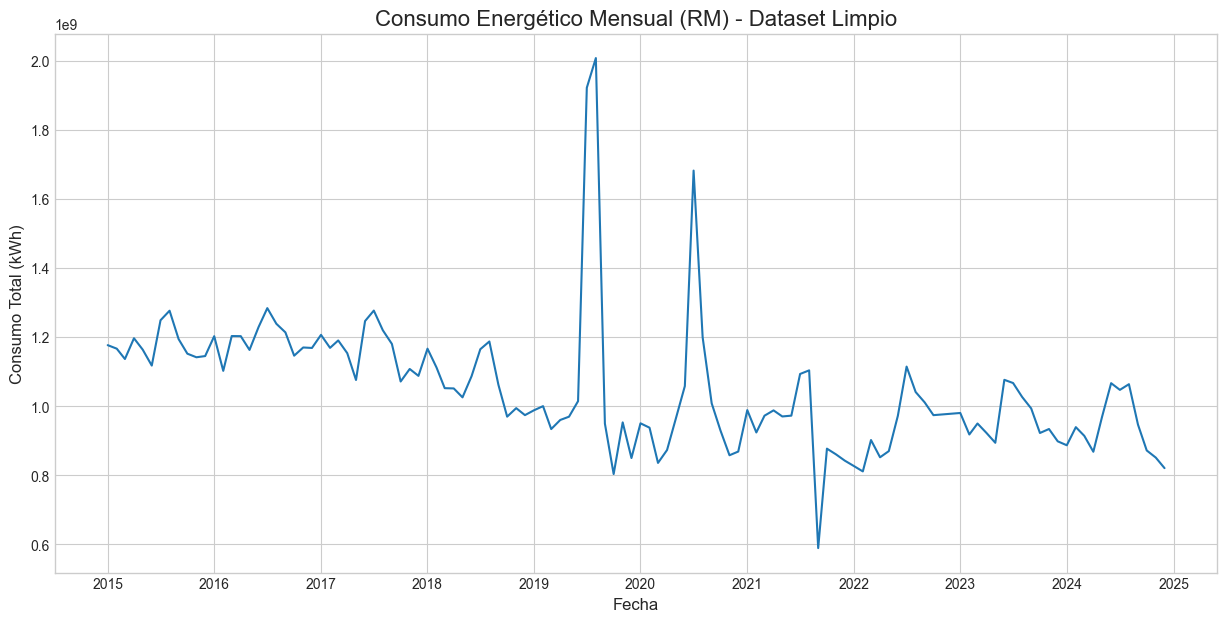

In [4]:
if not df_rm_final.empty:
    print("\nGraficando tendencia de consumo mensual RM (limpio)...")
    consumo_mensual_rm_limpio = df_rm_final.groupby('fecha')['energia_kwh'].sum().reset_index()

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(15, 7))
    sns.lineplot(data=consumo_mensual_rm_limpio, x='fecha', y='energia_kwh', ax=ax)
    ax.set_title('Consumo Energético Mensual (RM) - Dataset Limpio', fontsize=16)
    ax.set_xlabel('Fecha', fontsize=12)
    ax.set_ylabel('Consumo Total (kWh)', fontsize=12)
    plt.show()
else:
    print("No hay datos de consumo RM para graficar.")

## 2. Datos Meteorológicos (DMC)

### 2.1 Carga, Consolidación y Limpieza

In [5]:
# Función adaptada para procesar archivos DMC
def procesar_archivo_dmc(ruta_archivo, nombre_variable):
    try:
        # Ajustar skiprows según la inspección de los archivos CSV reales
        df = pd.read_csv(ruta_archivo, header=None, skiprows=3) 
        df_split = df.iloc[:, 0].str.split(';', expand=True)
        df_procesado = df_split.iloc[:, [0, 1, 2]] # Tomar las 3 primeras columnas
        df_procesado.columns = ['CodigoNacional', 'Instante', nombre_variable]
        
        df_procesado['Instante'] = pd.to_datetime(df_procesado['Instante'], errors='coerce')
        df_procesado[nombre_variable] = pd.to_numeric(df_procesado[nombre_variable], errors='coerce')
        
        # Eliminar filas con NaT en Instante o NaN en la variable
        df_procesado.dropna(subset=['Instante', nombre_variable], inplace=True)
        
        # Asegurar que CodigoNacional sea consistente (puede venir con texto)
        # Tomamos el primer código numérico válido como referencia
        codigo_valido = pd.to_numeric(df_procesado['CodigoNacional'], errors='coerce').dropna().iloc[0]
        df_procesado['CodigoNacional'] = int(codigo_valido) # Convertir a entero

        return df_procesado
    except Exception as e:
        print(f"Error procesando {ruta_archivo}: {e}")
        return pd.DataFrame()

In [6]:
print("--- CONSOLIDANDO Y PROCESANDO DATOS METEOROLÓGICOS (DMC) ---")
path_raw_data = os.path.join('..', 'data', 'raw') # Ajustado para buscar en data/raw
años = range(2015, 2026)
lista_temp, lista_max_temp, lista_min_temp = [], [], []

# Patrones de nombre de archivo (ajustar si es necesario)
patron_base = "330020_{año}_{tipo}_*.csv" 

for año in años:
    # Temperatura Media
    archivos_temp = glob.glob(os.path.join(path_raw_data, patron_base.format(año=año, tipo='Temperatura')))
    if archivos_temp:
        df_t = procesar_archivo_dmc(archivos_temp[0], 'Temperatura')
        if not df_t.empty: lista_temp.append(df_t)
    
    # Temperatura Máxima
    archivos_max = glob.glob(os.path.join(path_raw_data, patron_base.format(año=año, tipo='TMaxima')))
    if archivos_max:
        df_mx = procesar_archivo_dmc(archivos_max[0], 'T_Maxima')
        if not df_mx.empty: lista_max_temp.append(df_mx)

    # Temperatura Mínima
    archivos_min = glob.glob(os.path.join(path_raw_data, patron_base.format(año=año, tipo='TMinima')))
    if archivos_min:
        df_mn = procesar_archivo_dmc(archivos_min[0], 'T_Minima')
        if not df_mn.empty: lista_min_temp.append(df_mn)

# Concatenar y unir
df_clima_hourly = pd.DataFrame()
if lista_temp:
    df_clima_hourly = pd.concat(lista_temp, ignore_index=True)
    if lista_max_temp:
        max_temp_df = pd.concat(lista_max_temp, ignore_index=True)
        df_clima_hourly = pd.merge(df_clima_hourly, max_temp_df, on=['CodigoNacional', 'Instante'], how='outer')
    if lista_min_temp:
        min_temp_df = pd.concat(lista_min_temp, ignore_index=True)
        df_clima_hourly = pd.merge(df_clima_hourly, min_temp_df, on=['CodigoNacional', 'Instante'], how='outer')

    df_clima_hourly = df_clima_hourly.sort_values(by='Instante').reset_index(drop=True)
    df_clima_hourly.dropna(subset=['Temperatura', 'T_Maxima', 'T_Minima'], how='all', inplace=True)
    
    # Eliminar datos futuros (más allá de la fecha actual o límite)
    fecha_limite_clima = pd.to_datetime('today').normalize() # Usar fecha actual como límite
    df_clima_hourly = df_clima_hourly[df_clima_hourly['Instante'] < fecha_limite_clima]

    print("\n--- DATOS METEOROLÓGICOS HORARIOS CONSOLIDADOS ---")
    display(df_clima_hourly.head())
    display(df_clima_hourly.tail())
    df_clima_hourly.info()
else:
    print("Error: No se pudieron cargar datos de temperatura media.")

--- CONSOLIDANDO Y PROCESANDO DATOS METEOROLÓGICOS (DMC) ---


C:\Users\corre\AppData\Local\Temp\ipykernel_4252\3497314819.py:10: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_procesado['Instante'] = pd.to_datetime(df_procesado['Instante'], errors='coerce')
C:\Users\corre\AppData\Local\Temp\ipykernel_4252\3497314819.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_procesado['Instante'] = pd.to_datetime(df_procesado['Instante'], errors='coerce')
C:\Users\corre\AppData\Local\Temp\ipykernel_4252\3497314819.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu


--- DATOS METEOROLÓGICOS HORARIOS CONSOLIDADOS ---


,CodigoNacional,Instante,Temperatura,T_Maxima,T_Minima
0,330020,2015-01-01 00:00:00,21.3,30.2,14.6
1,330020,2015-01-01 01:00:00,19.4,NaN,NaN
2,330020,2015-01-01 02:00:00,17.9,NaN,NaN
3,330020,2015-01-01 03:00:00,17.1,NaN,NaN
4,330020,2015-01-01 04:00:00,17.0,NaN,NaN


,CodigoNacional,Instante,Temperatura,T_Maxima,T_Minima
94350,330020,2025-10-13 23:00:00,21.6,NaN,NaN
94351,330020,2025-10-14 00:00:00,19.5,NaN,NaN
94352,330020,2025-10-14 01:00:00,17.7,NaN,NaN
94353,330020,2025-10-14 02:00:00,16.8,NaN,NaN
94354,330020,2025-10-14 03:00:00,16.0,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
Index: 94355 entries, 0 to 94354
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   CodigoNacional  94355 non-null  int64         
 1   Instante        94355 non-null  datetime64[ns]
 2   Temperatura     94354 non-null  float64       
 3   T_Maxima        3732 non-null   float64       
 4   T_Minima        3731 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 4.3 MB


### 2.2 Agregación Diaria y Mensual

In [7]:
df_clima_mensual = pd.DataFrame() # Inicializar
if not df_clima_hourly.empty:
    print("\n--- AGREGANDO DATOS CLIMÁTICOS DIARIA Y MENSUALMENTE ---")
    
    # Agregación diaria para rellenar NaNs de T_Max/T_Min si es necesario
    df_clima_daily_agg = df_clima_hourly.set_index('Instante').resample('D').agg(
        Temp_Promedio_Diaria=('Temperatura', 'mean'),
        Temp_Maxima_Diaria=('T_Maxima', 'max'), # T_Maxima suele ser 1 valor/día
        Temp_Minima_Diaria=('T_Minima', 'min'), # T_Minima suele ser 1 valor/día
        Max_Temp_Respaldo=('Temperatura', 'max'), # Respaldo si T_Maxima falta
        Min_Temp_Respaldo=('Temperatura', 'min')  # Respaldo si T_Minima falta
    ).reset_index()

    # Rellenar NaNs diarios usando respaldos
    df_clima_daily_agg['Temp_Maxima_Diaria'].fillna(df_clima_daily_agg['Max_Temp_Respaldo'], inplace=True)
    df_clima_daily_agg['Temp_Minima_Diaria'].fillna(df_clima_daily_agg['Min_Temp_Respaldo'], inplace=True)
    df_clima_daily = df_clima_daily_agg.drop(columns=['Max_Temp_Respaldo', 'Min_Temp_Respaldo'])
    df_clima_daily.rename(columns={'Instante': 'fecha_dia'}, inplace=True)
    
    # Eliminar filas donde todas las temperaturas diarias sean NaN
    df_clima_daily.dropna(subset=['Temp_Promedio_Diaria', 'Temp_Maxima_Diaria', 'Temp_Minima_Diaria'], how='all', inplace=True)
    
    # Agregación mensual final
    df_clima_mensual = df_clima_daily.set_index('fecha_dia').resample('MS').agg(
        temperatura_promedio_c=('Temp_Promedio_Diaria', 'mean'),
        temperatura_maxima_c=('Temp_Maxima_Diaria', 'mean'), # Promedio de las máximas diarias del mes
        temperatura_minima_c=('Temp_Minima_Diaria', 'mean')  # Promedio de las mínimas diarias del mes
    ).reset_index()
    df_clima_mensual.rename(columns={'fecha_dia': 'fecha'}, inplace=True)

    # Rellenar posibles meses faltantes (ej., si faltan datos de un mes entero)
    df_clima_mensual = df_clima_mensual.ffill().bfill()

    print("Agregación mensual completada.")
    display(df_clima_mensual.head())
    df_clima_mensual.info()
else:
    print("No hay datos climáticos horarios para agregar.")


--- AGREGANDO DATOS CLIMÁTICOS DIARIA Y MENSUALMENTE ---
Agregación mensual completada.


C:\Users\corre\AppData\Local\Temp\ipykernel_4252\1388438356.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clima_daily_agg['Temp_Maxima_Diaria'].fillna(df_clima_daily_agg['Max_Temp_Respaldo'], inplace=True)
C:\Users\corre\AppData\Local\Temp\ipykernel_4252\1388438356.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we

,fecha,temperatura_promedio_c,temperatura_maxima_c,temperatura_minima_c
0,2015-01-01,22.259964,31.419355,13.793548
1,2015-02-01,21.395937,30.025000,13.439286
2,2015-03-01,20.986465,30.283871,12.858065
3,2015-04-01,16.933750,26.690000,9.326667
4,2015-05-01,12.576210,21.641935,6.232258


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   fecha                   130 non-null    datetime64[ns]
 1   temperatura_promedio_c  130 non-null    float64       
 2   temperatura_maxima_c    130 non-null    float64       
 3   temperatura_minima_c    130 non-null    float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 4.2 KB


## 3. Datos Socioeconómicos (INE/MDS)

### 3.1 Carga y Limpieza

In [13]:
# Ruta al archivo socioeconómico (suponiendo CSV)
# Asegúrate de tener este archivo en data/raw/
ruta_socio = os.path.join('..', 'data', 'raw', 'datos_socioeconomicos.csv') 
df_socio = pd.DataFrame() # Inicializar

try:
    # Leer el archivo, puede necesitar ajustes (encoding, separator, skiprows)
    df_socio_raw = pd.read_csv(ruta_socio, sep=';', encoding='latin1') 
    print("Archivo socioeconómico cargado.")
    
    # --- Limpieza Específica (EJEMPLO, AJUSTAR A TU ARCHIVO REAL) ---
    # Renombrar columnas relevantes
    # Asumiendo columnas como 'Anyo', 'Nombre Comuna', 'Indice Pobreza Multidimensional (%)'
    df_socio_raw = df_socio_raw.rename(columns={
        'Anyo': 'anio', 
        'Nombre Comuna': 'comuna_ine', # Usar nombre distinto para evitar conflicto antes de merge
        'Indice Pobreza Multidimensional (%)': 'indice_pobreza_pct'
        # Añadir otras columnas relevantes si las tienes (ej. Ingreso Promedio)
    })
    
    # Seleccionar columnas necesarias
    cols_socio_necesarias = ['anio', 'comuna_ine', 'indice_pobreza_pct']
    df_socio = df_socio_raw[cols_socio_necesarias].copy()
    
    # Limpiar nombres de comunas (ej. quitar tildes, convertir a mayúsculas/minúsculas)
    # Esto es CRUCIAL para el merge posterior. Debe coincidir con los nombres en df_rm_final['comuna']
    df_socio['comuna_ine'] = df_socio['comuna_ine'].str.strip().str.upper() # Ejemplo: quitar espacios y pasar a mayúsculas
    # Podrías necesitar un mapeo más complejo si los nombres difieren mucho
    
    # Convertir indice_pobreza_pct a numérico (puede venir como string con '%')
    if 'indice_pobreza_pct' in df_socio.columns:
        df_socio['indice_pobreza_pct'] = df_socio['indice_pobreza_pct'].astype(str).str.replace('%', '').str.replace(',', '.').str.strip()
        df_socio['indice_pobreza_pct'] = pd.to_numeric(df_socio['indice_pobreza_pct'], errors='coerce')
        df_socio.dropna(subset=['indice_pobreza_pct'], inplace=True)
    
    print("\n--- DATOS SOCIOECONÓMICOS LIMPIOS ---")
    display(df_socio.head())
    df_socio.info()

except FileNotFoundError:
    print(f"Advertencia: No se encontró el archivo socioeconómico en: {ruta_socio}. Se continuará sin estos datos.")
except KeyError as e:
     print(f"Error de columna procesando datos socioeconómicos: {e}. Verifica los nombres de columna.")
except Exception as e:
    print(f"Ocurrió un error al procesar el archivo socioeconómico: {e}")
    df_socio = pd.DataFrame() # Resetear en caso de error grave

Archivo socioeconómico cargado.
Ocurrió un error al procesar el archivo socioeconómico: Can only use .str accessor with string values!


## 4. Fusión Final: Energía + Clima + Socioeconómico

In [14]:
df_final = pd.DataFrame() # Inicializar
if not df_rm_final.empty and not df_clima_mensual.empty:
    print("\n--- FUSIONANDO DATOS DE ENERGÍA Y CLIMA ---")
    df_final = pd.merge(df_rm_final, df_clima_mensual, on='fecha', how='left')
    
    # Rellenar nulos de clima post-merge (importante si los rangos de fecha no son idénticos)
    cols_clima = ['temperatura_promedio_c', 'temperatura_maxima_c', 'temperatura_minima_c']
    for col in cols_clima:
        if col in df_final.columns:
            df_final[col] = df_final[col].fillna(method='ffill').fillna(method='bfill')
    print("Datos de clima fusionados y nulos rellenados.")

    if not df_socio.empty:
        print("\n--- FUSIONANDO CON DATOS SOCIOECONÓMICOS ---")
        # Preparar columna 'comuna' en df_final para el merge (ej. a mayúsculas)
        df_final['comuna_merge'] = df_final['comuna'].str.strip().str.upper()
        
        # Realizar el merge usando 'anio' y las columnas de comuna limpias
        df_final = pd.merge(df_final, df_socio, 
                            left_on=['anio', 'comuna_merge'], 
                            right_on=['anio', 'comuna_ine'], 
                            how='left')
        
        # Eliminar columnas auxiliares del merge
        df_final.drop(columns=['comuna_merge', 'comuna_ine'], inplace=True)
        
        # Verificar nulos en la columna socioeconómica
        print("Valores nulos en 'indice_pobreza_pct' después de la fusión:")
        print(df_final['indice_pobreza_pct'].isnull().sum())
        
        # Rellenar nulos socioeconómicos (ej. usando la media/mediana o ffill/bfill por comuna/año)
        # Estrategia simple: ffill/bfill general (puede no ser ideal para datos anuales)
        if 'indice_pobreza_pct' in df_final.columns:
            df_final['indice_pobreza_pct'] = df_final['indice_pobreza_pct'].fillna(method='ffill').fillna(method='bfill')
        print("Datos socioeconómicos fusionados y nulos rellenados (método simple).")
    else:
        print("\nSe omite la fusión socioeconómica porque no se cargaron los datos.")

    print("\n--- DATAFRAME FINAL COMBINADO ---")
    display(df_final.head())
    df_final.info()

elif not df_rm_final.empty:
    print("Advertencia: No se pudieron cargar o procesar los datos climáticos. El DF final solo contendrá datos de energía.")
    df_final = df_rm_final.copy()
else:
    print("Error: No se pudieron cargar los datos de energía. El DF final está vacío.")



--- FUSIONANDO DATOS DE ENERGÍA Y CLIMA ---
Datos de clima fusionados y nulos rellenados.

Se omite la fusión socioeconómica porque no se cargaron los datos.

--- DATAFRAME FINAL COMBINADO ---


C:\Users\corre\AppData\Local\Temp\ipykernel_4252\3280655110.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_final[col] = df_final[col].fillna(method='ffill').fillna(method='bfill')


,anio,mes,region,comuna,tipo_clientes,tarifa,clientes_facturados,e1_kwh,e2_kwh,energia_kwh,fecha,temperatura_promedio_c,temperatura_maxima_c,temperatura_minima_c
0,2015,1,RegiÃ³n Metropolitana de Santiago,MaipÃº,No Residencial,BT4.1,1.0,1415.0,0.0,1415,2015-01-01,22.259964,31.419355,13.793548
1,2015,1,RegiÃ³n Metropolitana de Santiago,MaipÃº,No Residencial,BT3PPP,55.0,198996.0,0.0,198996,2015-01-01,22.259964,31.419355,13.793548
2,2015,1,RegiÃ³n Metropolitana de Santiago,MaipÃº,No Residencial,BT3PP,411.0,1635743.0,0.0,1635743,2015-01-01,22.259964,31.419355,13.793548
3,2015,1,RegiÃ³n Metropolitana de Santiago,MaipÃº,No Residencial,BT4.2,1.0,1915.0,0.0,1915,2015-01-01,22.259964,31.419355,13.793548
4,2015,1,RegiÃ³n Metropolitana de Santiago,MarÃ­a Pinto,No Residencial,AT2PP,1.0,3127.0,0.0,3127,2015-01-01,22.259964,31.419355,13.793548


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73662 entries, 0 to 73661
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   anio                    73662 non-null  int64         
 1   mes                     73662 non-null  int64         
 2   region                  73662 non-null  object        
 3   comuna                  73662 non-null  object        
 4   tipo_clientes           73662 non-null  object        
 5   tarifa                  73662 non-null  object        
 6   clientes_facturados     73662 non-null  float64       
 7   e1_kwh                  73662 non-null  float64       
 8   e2_kwh                  73662 non-null  float64       
 9   energia_kwh             73662 non-null  int64         
 10  fecha                   73662 non-null  datetime64[ns]
 11  temperatura_promedio_c  73662 non-null  float64       
 12  temperatura_maxima_c    73662 non-null  float6

## 5. Ingeniería de Características Adicionales

In [15]:
if not df_final.empty:
    print("\n--- CREANDO CARACTERÍSTICAS TEMPORALES FINALES ---")
    df_final['trimestre'] = df_final['fecha'].dt.quarter
    df_final['inicio_mes'] = df_final['fecha'].dt.is_month_start.astype(int)
    # Se podrían crear más: lags, interacciones, etc.
    print("Características adicionales creadas.")
    display(df_final[['fecha', 'anio', 'mes', 'trimestre', 'inicio_mes']].head())
else:
    print("No hay datos para crear características.")


--- CREANDO CARACTERÍSTICAS TEMPORALES FINALES ---
Características adicionales creadas.


,fecha,anio,mes,trimestre,inicio_mes
0,2015-01-01,2015,1,1,1
1,2015-01-01,2015,1,1,1
2,2015-01-01,2015,1,1,1
3,2015-01-01,2015,1,1,1
4,2015-01-01,2015,1,1,1


## 6. Análisis Exploratorio de Datos (EDA) Combinado

Exploramos relaciones en el dataset final.


--- EDA: CORRELACIÓN ENTRE VARIABLES NUMÉRICAS ---


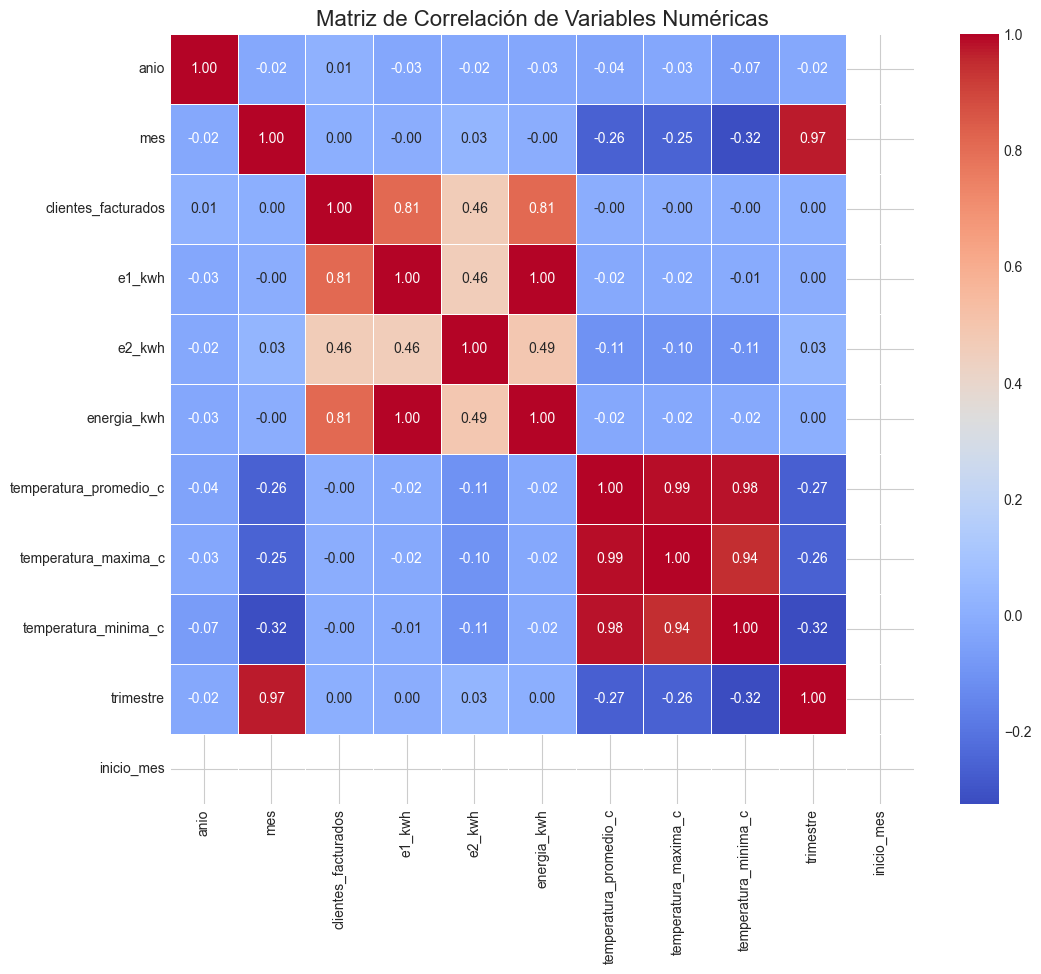


--- EDA: Consumo vs Temperatura Promedio ---


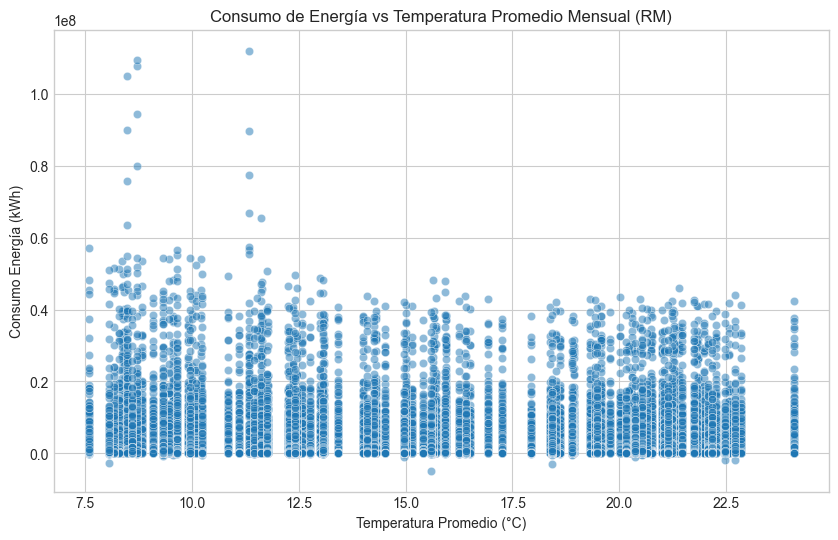

In [16]:
if not df_final.empty:
    print("\n--- EDA: CORRELACIÓN ENTRE VARIABLES NUMÉRICAS ---")
    
    # Seleccionar solo columnas numéricas para la matriz de correlación
    df_numeric = df_final.select_dtypes(include=np.number)
    
    # Calcular la matriz de correlación
    correlation_matrix = df_numeric.corr()

    # Visualizar la matriz de correlación
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('Matriz de Correlación de Variables Numéricas', fontsize=16)
    plt.show()
    
    # Explorar relación Consumo vs Temperatura
    print("\n--- EDA: Consumo vs Temperatura Promedio ---")
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df_final, x='temperatura_promedio_c', y='energia_kwh', alpha=0.5)
    plt.title('Consumo de Energía vs Temperatura Promedio Mensual (RM)')
    plt.xlabel('Temperatura Promedio (°C)')
    plt.ylabel('Consumo Energía (kWh)')
    plt.show()
    
    # Explorar relación Consumo vs Índice de Pobreza (si existe)
    if 'indice_pobreza_pct' in df_final.columns:
        print("\n--- EDA: Consumo vs Índice de Pobreza ---")
        plt.figure(figsize=(10, 6))
        # Agrupar por comuna y año para tener un punto por comuna/año
        df_agg_socio = df_final.groupby(['anio', 'comuna'])[['energia_kwh', 'indice_pobreza_pct']].mean().reset_index()
        sns.scatterplot(data=df_agg_socio, x='indice_pobreza_pct', y='energia_kwh', alpha=0.6)
        plt.title('Consumo Promedio de Energía vs Índice de Pobreza (por Comuna/Año)')
        plt.xlabel('Índice de Pobreza Multidimensional (%)')
        plt.ylabel('Consumo Energía Promedio (kWh)')
        plt.show()
else:
     print("No hay datos para realizar EDA.")

## 7. Guardar DataFrame Final Procesado

In [17]:
if not df_final.empty:
    print("\n--- GUARDANDO DATAFRAME FINAL PROCESADO ---")
    ruta_destino_final = os.path.join('..', 'data', 'processed', 'dataset_final_energia_clima_socio.csv')
    try:
        # Seleccionar y reordenar columnas para claridad
        columnas_finales = [
            'fecha', 'anio', 'mes', 'trimestre', 'inicio_mes', 'region', 'comuna',
            'tipo_clientes', 'tarifa', 'clientes_facturados', 'e1_kwh', 'e2_kwh', 
            'energia_kwh', 'temperatura_promedio_c', 'temperatura_maxima_c', 
            'temperatura_minima_c'
        ]
        # Añadir columna socioeconómica si existe
        if 'indice_pobreza_pct' in df_final.columns:
            columnas_finales.append('indice_pobreza_pct')
        
        # Filtrar solo columnas existentes en el orden deseado
        columnas_existentes_final = [col for col in columnas_finales if col in df_final.columns]
        
        df_final[columnas_existentes_final].to_csv(ruta_destino_final, index=False)
        print(f"DataFrame final combinado guardado en: {ruta_destino_final}")
    except Exception as e:
        print(f"Error al guardar el archivo final: {e}")
else:
    print("No hay dataframe final para guardar.")


--- GUARDANDO DATAFRAME FINAL PROCESADO ---
DataFrame final combinado guardado en: ..\data\processed\dataset_final_energia_clima_socio.csv
